In [1]:
import numpy as np
import torch
from torch import nn as nn
import pandas as pd
import os

#random generate 224*224*3
img_1 = np.random.rand(224,224,3)
img_1 = torch.from_numpy(img_1)
#将image1转为float
img_1 = img_1.float()
img_1 = img_1.unsqueeze(0)

c:\Users\Bacon\.conda\envs\samuel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
a = None
if a:
    print(3)

In [1]:
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu
# --------------------------------------------------------

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = (
        x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    )
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(
        B, H // window_size, W // window_size, window_size, window_size, -1
    )
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x



c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
class PatchMerging(nn.Module):
    r"""Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C
        print(x.shape)

        x = self.norm(x)
        x = self.reduction(x)
        print(x.shape)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim

In [5]:
patch_1 = PatchMerging(input_resolution=(224,224), dim=3)
img_patch_1 = patch_1.forward(img_1.reshape(1,-1,3))

NameError: name 'PatchMerging' is not defined

In [33]:
img_patch_1.shape

torch.Size([1, 12544, 6])

In [17]:
mlp_1 = Mlp(in_features=4*4*3, hidden_features=None, out_features=4*4*6, act_layer=nn.GELU, drop=0.0)
window_partition(img_1, 4).shape

torch.Size([3136, 4, 4, 3])

In [12]:
from collections import Counter

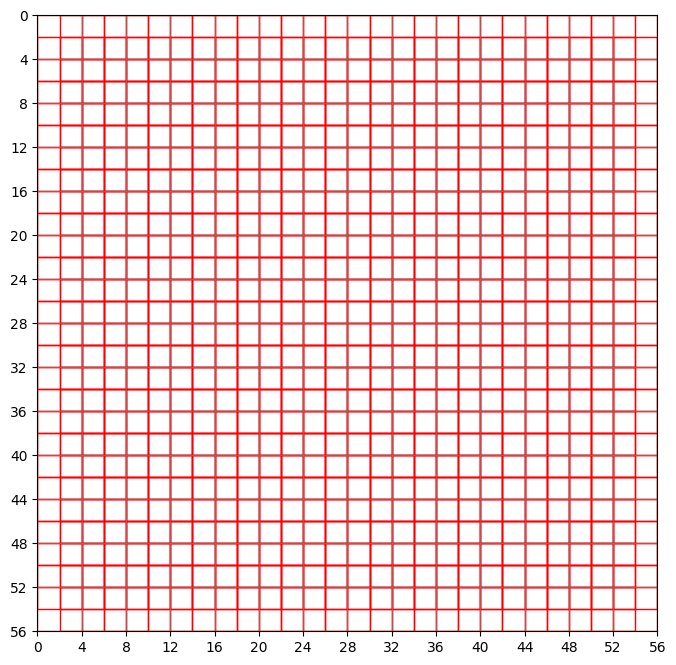

In [128]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_windows(img_size, window_size, shift_size):
    fig, ax = plt.subplots(figsize=(8, 8))

    # 绘制原始图像
    ax.set_xlim(0, img_size)
    ax.set_ylim(0, img_size)
    ax.set_xticks(range(0, img_size+1, window_size))
    ax.set_yticks(range(0, img_size+1, window_size))
    plt.grid(True, which='both', color='gray', linewidth=0.5)

    # 添加窗口
    for x in range(0, img_size, shift_size):
        for y in range(0, img_size, shift_size):
            if x + window_size <= img_size and y + window_size <= img_size:
                rect = patches.Rectangle((x, y), window_size, window_size, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

    plt.gca().invert_yaxis()  # y轴反向，使图像与常规坐标系统一致
    plt.show()

# 参数
img_size = 56
window_size = 4
shift_size = 2

draw_windows(img_size, window_size, shift_size)


In [3]:
a = [1,2,3,4,5,6,7]
a[5:]
a[-5:]

[3, 4, 5, 6, 7]

In [2]:
import pandas as pd


In [4]:
all_scans_data = pd.read_excel('../../New_Extra_Data/combination_archive_with_dates.xlsx')

In [9]:
len(all_scans_data['PID Lokaal'].unique())

497

In [10]:
all_hgp_scores = pd.read_excel('../../New_Extra_Data/CRLM_Status_230622.xlsx')

In [16]:
all_access_scans = pd.read_csv('../../New_Extra_Data/CILM_xnatsort_20230323.csv')

In [3]:
import pandas as pd

all_scans_data = pd.read_csv('../Phase_Detector/Data/Final_Phase_Label.csv')

In [4]:
pd.value_counts(all_scans_data['Phase'])

2    105
1     96
0     62
Name: Phase, dtype: int64

In [11]:

class WindowAttention(nn.Module):
    r"""Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
    ):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
        )  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = (
            coords_flatten[:, :, None] - coords_flatten[:, None, :]
        )  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(
            1, 2, 0
        ).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        print(B_, N, C,'6666')
        qkv = (
            self.qkv(x)
            .reshape(B_, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        print(attn.shape,'111')
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)
        ].view(
            self.window_size[0] * self.window_size[1],
            self.window_size[0] * self.window_size[1],
            -1,
        )  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(
            2, 0, 1
        ).contiguous()  # nH, Wh*Ww, Wh*Ww
        #print(relative_position_bias.shape,'666')
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            #mask值设为-100不为关注！
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(
                1
            ).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}"

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r"""Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(
        self,
        dim,
        input_resolution,
        num_heads,
        window_size=7,
        shift_size=0,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert (
            0 <= self.shift_size < self.window_size
        ), "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=to_2tuple(self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

        if self.shift_size > 0:
            #这里其实是每个window像右下shift因此需要mask计算的是每个windowsize里的mask！
            
            # calculate attention mask for SW-MSA
            #是先算mask再叠加到计算好的attention上！
            #再mask到计算好后的上面！注意对角线采用一二维相减！
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            print(f" mask  {img_mask.flatten().tolist()}")
            mask_windows = window_partition(
                img_mask, self.window_size
            )  # nW, window_size, window_size, 1
            print(f"hi mask{Counter(mask_windows.flatten().tolist())}")
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            print(f"this is mask1 {mask_windows.unsqueeze(1).shape},and mask 2 {mask_windows.unsqueeze(2).shape}")
            print(f" atten mask{attn_mask.shape}")
            attn_mask = attn_mask.masked_fill(
                attn_mask != 0, float(-100.0)
            ).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        print('num of heads',self.num_heads)
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(
                x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2)
            )
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(
            shifted_x, self.window_size
        )  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(
            -1, self.window_size * self.window_size, C
        )  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        #这里是先rollwindow后计算atten再mask,mask就是shift后的图像上对应的位置
        attn_windows = self.attn(
            x_windows, mask=self.attn_mask
        )  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(
                shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2)
            )
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return (
            f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, "
            f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"
        )

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r"""Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(
        self,
        dim,
        input_resolution,
        depth,
        num_heads,
        window_size,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        norm_layer=nn.LayerNorm,
        downsample=None,
        use_checkpoint=False,
    ):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    input_resolution=input_resolution,
                    num_heads=num_heads,
                    window_size=window_size,
                    shift_size=0 if (i % 2 == 0) else window_size // 2,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i]
                    if isinstance(drop_path, list)
                    else drop_path,
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, norm_layer=norm_layer
            )
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r"""Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(
        self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [
            img_size[0] // patch_size[0],
            img_size[1] // patch_size[1],
        ]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert (
            H == self.img_size[0] and W == self.img_size[1]
        ), f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = (
            Ho
            * Wo
            * self.embed_dim
            * self.in_chans
            * (self.patch_size[0] * self.patch_size[1])
        )
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


In [46]:
a  = a.flatten().unsqueeze(0)

In [48]:
a

tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [47]:
a.unsqueeze(1)-a.unsqueeze(2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
         [-1,  0,  1,  2,  3,  4,  5,  6,  7],
         [-2, -1,  0,  1,  2,  3,  4,  5,  6],
         [-3, -2, -1,  0,  1,  2,  3,  4,  5],
         [-4, -3, -2, -1,  0,  1,  2,  3,  4],
         [-5, -4, -3, -2, -1,  0,  1,  2,  3],
         [-6, -5, -4, -3, -2, -1,  0,  1,  2],
         [-7, -6, -5, -4, -3, -2, -1,  0,  1],
         [-8, -7, -6, -5, -4, -3, -2, -1,  0]]])

In [45]:
import torch
a = [1,2,3,4,5,6,7,8,9]
a = torch.tensor(a).reshape(3,3)
c = torch.tensor(a).unsqueeze(1) - torch.tensor(a).unsqueeze(2)
c

C:\Users\Bacon\AppData\Local\Temp\ipykernel_4872\3017939059.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(a).unsqueeze(1) - torch.tensor(a).unsqueeze(2)


tensor([[[ 0,  1,  2],
         [-1,  0,  1],
         [-2, -1,  0]],

        [[ 0,  1,  2],
         [-1,  0,  1],
         [-2, -1,  0]],

        [[ 0,  1,  2],
         [-1,  0,  1],
         [-2, -1,  0]]])

In [5]:
import pandas as pd

data = pd.read_csv('../Phase_Detector/Phase_Label.csv')
data_1 = data[(data['Phase'] != "Other") & (data['Phase'] != "Unknown")]

In [10]:
patch_embed = PatchEmbed()
img_1 = img_1.permute(0,3,1,2)

In [50]:
#patch_embd_1 = patch_embed.forward(img_1)
patch_merg = PatchMerging((56,56),96)
#patch_merg_1 = patch_merg.forward(patch_embd_1)
swin_attn = SwinTransformerBlock(96,(56,56),3,shift_size=3)

 mask  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [105]:
patch_embd_1.shape

torch.Size([1, 3136, 96])

In [108]:
#计算attention
#改dim为1,64，-1,192；-1代表自动计算
patch_embd_1_attn = patch_embd_1.reshape(64,49,-1)
#forward 的不是同一个!
swin_attn.forward(patch_embd_1).shape

64 49 96 6666
torch.Size([64, 3, 49, 49]) 111


torch.Size([1, 3136, 96])

In [78]:
class MyTransformer(nn.Module):
    def __init__(self, window_size):
        super().__init__()
        self.window_size = window_size

    def my_method(self):
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
        print(coords.shape,'666666666')  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        print('666',coords_flatten.shape,'666')
        relative_coords = (
            coords_flatten[:, :, None] - coords_flatten[:, None, :]
        )  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(
            1, 2, 0
        ).contiguous()  # Wh*Ww, Wh*Ww, 2
        print(relative_coords)
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)


my_transformer = MyTransformer((7,7))
my_transformer.my_method()

torch.Size([2, 7, 7]) 666666666
666 torch.Size([2, 49]) 666
tensor([[[ 0,  0],
         [ 0, -1],
         [ 0, -2],
         ...,
         [-6, -4],
         [-6, -5],
         [-6, -6]],

        [[ 0,  1],
         [ 0,  0],
         [ 0, -1],
         ...,
         [-6, -3],
         [-6, -4],
         [-6, -5]],

        [[ 0,  2],
         [ 0,  1],
         [ 0,  0],
         ...,
         [-6, -2],
         [-6, -3],
         [-6, -4]],

        ...,

        [[ 6,  4],
         [ 6,  3],
         [ 6,  2],
         ...,
         [ 0,  0],
         [ 0, -1],
         [ 0, -2]],

        [[ 6,  5],
         [ 6,  4],
         [ 6,  3],
         ...,
         [ 0,  1],
         [ 0,  0],
         [ 0, -1]],

        [[ 6,  6],
         [ 6,  5],
         [ 6,  4],
         ...,
         [ 0,  2],
         [ 0,  1],
         [ 0,  0]]])


In [140]:
a.unsqueeze(2).shape

torch.Size([5, 5, 1])

In [166]:
class MyClass:
    def __init__(self):
        self.window_size = 7
        self.shift_size = 3
        self.img_mask  = torch.zeros((1, 8, 8, 1))
        print(self.img_mask.shape)
    def my_method(self):
        h_slices = (
            slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None),
        )
        w_slices = (
            slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None),
        )
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                self.img_mask[:, h, w, :] = cnt 
                cnt += 1
        return self.img_mask

my_class = MyClass()
final = my_class.my_method()




torch.Size([1, 8, 8, 1])


In [191]:
from collections import Counter
Counter(list(final.flatten().tolist()))

Counter({4.0: 16,
         5.0: 12,
         7.0: 12,
         8.0: 9,
         1.0: 4,
         3.0: 4,
         2.0: 3,
         6.0: 3,
         0.0: 1})

In [144]:
H, W = 7,7
img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1


In [141]:
#设计一个5x5数组
a = torch.arange(25).reshape(5,5)
a[-5:-2,-5:-2]

tensor([[ 0,  1,  2],
        [ 5,  6,  7],
        [10, 11, 12]])

In [143]:
a[0:-5,0:-5]

tensor([], size=(0, 0), dtype=torch.int64)

In [135]:
h_slice = slice(-2,None)
w_slice = slice(-2,None)

In [136]:
a[h_slice,w_slice]

tensor([[18, 19],
        [23, 24]])

In [56]:
a

['CT_10104',
 'CT_10203',
 'CT_10455',
 'CT_10785',
 'CT_11111',
 'CT_11155',
 'CT_11447',
 'CT_11656',
 'CT_12190',
 'CT_12545',
 'CT_12553',
 'CT_12931',
 'CT_12957',
 'CT_13419',
 'CT_13714',
 'CT_13999',
 'CT_14025',
 'CT_14146',
 'CT_14151',
 'CT_14299',
 'CT_14776',
 'CT_15014',
 'CT_15300',
 'CT_15566',
 'CT_15813',
 'CT_16078',
 'CT_16466',
 'CT_16641',
 'CT_17684',
 'CT_19046',
 'CT_19082',
 'CT_19381',
 'CT_19738',
 'CT_19876',
 'CT_19901',
 'CT_20185',
 'CT_20299',
 'CT_20370',
 'CT_20646',
 'CT_20985',
 'CT_21017',
 'CT_21103',
 'CT_21114',
 'CT_21502',
 'CT_21564',
 'CT_21919',
 'CT_21927',
 'CT_22762',
 'CT_22829',
 'CT_22958',
 'CT_23288',
 'CT_23350',
 'CT_23517',
 'CT_24329',
 'CR_24329',
 'CT_24650',
 'CT_25359',
 'CT_25522',
 'CT_25531',
 'CT_25615',
 'CT_25848',
 'CT_25963',
 'CT_26140',
 'CT_26579',
 'CT_26885',
 'CT_27035',
 'CT_27139',
 'CT_27158',
 'CT_27167',
 'CT_27232',
 'CT_27479',
 'CT_27750',
 'CT_27862',
 'CT_27925',
 'CT_28467',
 'CT_30065',
 'CT_30136',

In [82]:
import pandas as pd

original_data = pd.DataFrame({
    'experiment': ['experiment1', 'experiment2', 'experiment3', 'experiment4'],
    'scan': [5, 10, 15, 20],
    'other_column1': ['a', 'b', 'c', 'd'],
    'other_column2': [1, 2, 3, 4]
})

print(original_data)

filtered_data = pd.DataFrame({
    'experiment': ['experiment1', 'experiment3'],
    'scan': [5, 15]
})

print(filtered_data)


    experiment  scan other_column1  other_column2
0  experiment1     5             a              1
1  experiment2    10             b              2
2  experiment3    15             c              3
3  experiment4    20             d              4
    experiment  scan
0  experiment1     5
1  experiment3    15


In [87]:
def a_b(num=None):
    return num or 3

a_b(4)


4

In [70]:
data_1[data_1['Subject'].isin(b)]

,Unnamed: 0,Subject,Experiment,Insert_Date,Scan,Series_description,Modality,Manufacturer,Headtype,Subtype,...,seriesdate,acquisition_type,gender,age,birthdate,patient_ID,scanning_sequence,model_name,patient_position,Phase


In [104]:
img_mask = torch.zeros((1, 49, 49, 1))
img_mask[:, h1, w1, :].shape

torch.Size([1, 2, 2, 1])

In [192]:
swin_trans = SwinTransformerBlock(96,(56,56),3,shift_size=3)
swin_trans.forward(patch_embd_1).shape

fuck mask aaa Counter({0.0: 2401, 1.0: 196, 3.0: 196, 2.0: 147, 6.0: 147, 4.0: 16, 5.0: 12, 7.0: 12, 8.0: 9})
fuck masktorch.Size([64, 7, 7, 1])
64 49 96 6666
torch.Size([64, 3, 49, 49]) 111


torch.Size([1, 3136, 96])

In [182]:
import collections

In [ ]:


class SwinTransformer(nn.Module):
    r"""Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(
        self,
        img_size=224,
        patch_size=4,
        in_chans=3,
        num_classes=2,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        norm_layer=nn.LayerNorm,
        ape=False,
        patch_norm=True,
        use_checkpoint=False,
        **kwargs,
    ):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,
        )
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(
                torch.zeros(1, num_patches, embed_dim)
            )
            trunc_normal_(self.absolute_pos_embed, std=0.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))
        ]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                input_resolution=(
                    patches_resolution[0] // (2**i_layer),
                    patches_resolution[1] // (2**i_layer),
                ),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                use_checkpoint=use_checkpoint,
            )
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = (
            nn.Linear(self.num_features, num_classes)
            if num_classes > 0
            else nn.Identity()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"absolute_pos_embed"}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {"relative_position_bias_table"}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += (
            self.num_features
            * self.patches_resolution[0]
            * self.patches_resolution[1]
            // (2**self.num_layers)
        )
        flops += self.num_features * self.num_classes
        return flops

In [61]:
import pyxnat
import pyxnat

# XNAT服务器的URL
xnat_url = 'https://bigr-rad-xnat.erasmusmc.nl'

# 用户的凭据
username = 'yliu'
password = 'x37vnp78'

# 连接到XNAT
with pyxnat.Interface(server=xnat_url, user=username, password=password) as xnat:

    # 指定项目、主题和实验
    project_id = 'CILM'
    #subject_id = 'your_subject_id'
   # experiment_id = 'your_experiment_id'

    # 指定要上传的文件路径
    #file_path = '/path/to/your/file'

    # 创建主题和实验（如果它们不存在）
    #if not xnat.select.project(project_id).exists():
   #     xnat.select.project(project_id).create()
   # if not xnat.select.subject(subject_id).exists():
    #    xnat.select.project(project_id).subject(subject_id).create()
    #if not xnat.select.experiment(experiment_id).exists():
     #   xnat.select.project(project_id).subject(subject_id).experiment(experiment_id).create()

    # 上传文件
   # xnat.select.project(project_id).subject(subject_id).experiment(experiment_id).resource('new_resource').file(file_path.split('/')[-1]).put(file_path, overwrite=True)

    #print("File uploaded successfully.")
    #get project
    project = xnat.select.project(project_id)
    #get all subjuects
    subjects = project.subjects
    

In [4]:
import nibabel as nib
a = nib.load('../Test_Data/Raw_Phase_data/CILM_CT_229581_0000.nii.gz')
b = nib.load('../Test_Data/Seg_Phase_Data/CILM_CT_229581.nii.gz')

In [6]:
mask_a = b.get_fdata()

mask_a[mask_a==2]=1

In [8]:
import skimage
labeled = skimage.measure.label(mask_a, connectivity=2)
labeled[labeled != 1] = 0
mask = labeled

In [9]:
mask[mask!=1]=0

In [10]:
mask.sum()

767547

In [1]:
#count time
import time
a = [i for i in range(100000000)]
b = [i for i in range(100000)]


In [4]:
#calculate time
start = time.time()
for i in a:
    pass
end = time.time()

print(end-start)

#calculate time
start = time.time()
for i in range(100000000):
    next(iter(a))
end = time.time()

2.6330320835113525


KeyboardInterrupt: 

In [64]:
import xnat
xnat_session = xnat.connect('https://bigr-rad-xnat.erasmusmc.nl', user='yliu', password='x37vnp78')
xnat_project = xnat_session.projects['CILM']

In [65]:
import pandas as pd
data_scans = pd.read_csv('../../../Eramus_project/Code/CRLM_Samuel-main/scans_used_all_info.csv')

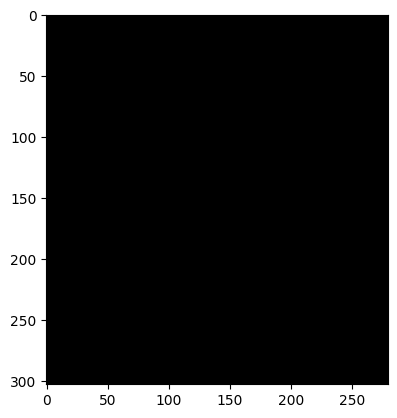

In [110]:
a = nib.load('../Test_Data/CILM_CT_696440_0000.nii.gz')
b = nib.load('../Test_Data/CILM_CT_696440.nii.gz')
import matplotlib.pyplot as plt
plt.imshow(a.get_fdata()[:,:,:],cmap='gray')
#plt.imshow(b.get_fdata()[:,:,20],cmap='gray')

In [112]:
b = b.get_fdata()
b[b==2]=1

In [113]:
import skimage
labeld = skimage.measure.label(b,connectivity=2)

In [114]:
labeld[labeld!=1]=0


In [119]:
image_probs = skimage.measure.regionprops((labeld))
for props in image_probs:
    bbox = props.bbox
    min_row, min_col, min_slice, max_row, max_col, max_slice = bbox 

In [120]:
print(min_row, min_col, min_slice, max_row, max_col, max_slice)

52 162 4 349 413 32


In [121]:
import nibabel as nib
image_a = nib.load('../Test_Data/Cropped_Data/CILM_CT_696440_0000.nii.gz')
image_b = nib.load('../Test_Data/Samule_Data/CT_24836/scans/1-Ax_5_4_LONG/resources/NIFTI/files/image.nii.gz')

In [18]:
# Test Swing transformer
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu
# --------------------------------------------------------

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = (
        x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    )
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(
        B, H // window_size, W // window_size, window_size, window_size, -1
    )
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r"""Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
    ):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
        )  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = (
            coords_flatten[:, :, None] - coords_flatten[:, None, :]
        )  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(
            1, 2, 0
        ).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B_, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)
        print(q.shape,'q.shape')

        q = q * self.scale
        attn = q @ k.transpose(-2, -1)

        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)
        ].view(
            self.window_size[0] * self.window_size[1],
            self.window_size[0] * self.window_size[1],
            -1,
        )  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(
            2, 0, 1
        ).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(
                1
            ).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)
        print(attn.shape,'attention shape')
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        print(x.shape,'after attention x shape')
        x = self.proj(x)
        x = self.proj_drop(x)
        print(x.shape,'x.shape,attention')
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}"

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r"""Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(
        self,
        dim,
        input_resolution,
        num_heads,
        window_size=7,
        shift_size=0,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert (
            0 <= self.shift_size < self.window_size
        ), "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=to_2tuple(self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(
                img_mask, self.window_size
            )  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(
                attn_mask != 0, float(-100.0)
            ).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(
                x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2)
            )
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(
            shifted_x, self.window_size
        )  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(
            -1, self.window_size * self.window_size, C
        )  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(
            x_windows, mask=self.attn_mask
        )  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(
                shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2)
            )
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return (
            f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, "
            f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"
        )

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r"""Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(
        self,
        dim,
        input_resolution,
        depth,
        num_heads,
        window_size,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        norm_layer=nn.LayerNorm,
        downsample=None,
        use_checkpoint=False,
    ):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    input_resolution=input_resolution,
                    num_heads=num_heads,
                    window_size=window_size,
                    shift_size=0 if (i % 2 == 0) else window_size // 2,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i]
                    if isinstance(drop_path, list)
                    else drop_path,
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, norm_layer=norm_layer
            )
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r"""Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(
        self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [
            img_size[0] // patch_size[0],
            img_size[1] // patch_size[1],
        ]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert (
            H == self.img_size[0] and W == self.img_size[1]
        ), f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = (
            Ho
            * Wo
            * self.embed_dim
            * self.in_chans
            * (self.patch_size[0] * self.patch_size[1])
        )
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r"""Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(
        self,
        img_size=224,
        patch_size=4,
        in_chans=3,
        num_classes=2,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        norm_layer=nn.LayerNorm,
        ape=False,
        patch_norm=True,
        use_checkpoint=False,
        **kwargs,
    ):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,
        )
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(
                torch.zeros(1, num_patches, embed_dim)
            )
            trunc_normal_(self.absolute_pos_embed, std=0.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))
        ]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                input_resolution=(
                    patches_resolution[0] // (2**i_layer),
                    patches_resolution[1] // (2**i_layer),
                ),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                use_checkpoint=use_checkpoint,
            )
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = (
            nn.Linear(self.num_features, num_classes)
            if num_classes > 0
            else nn.Identity()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"absolute_pos_embed"}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {"relative_position_bias_table"}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += (
            self.num_features
            * self.patches_resolution[0]
            * self.patches_resolution[1]
            // (2**self.num_layers)
        )
        flops += self.num_features * self.num_classes
        return flops

In [19]:
rand_image = torch.rand(1, 3, 224, 224)
model = SwinTransformer()


In [20]:
model(rand_image)

torch.Size([64, 3, 49, 32]) q.shape
torch.Size([64, 3, 49, 49]) attention shape
torch.Size([64, 49, 96]) after attention x shape
torch.Size([64, 49, 96]) x.shape,attention
torch.Size([64, 3, 49, 32]) q.shape
torch.Size([64, 3, 49, 49]) attention shape
torch.Size([64, 49, 96]) after attention x shape
torch.Size([64, 49, 96]) x.shape,attention
torch.Size([16, 6, 49, 32]) q.shape
torch.Size([16, 6, 49, 49]) attention shape
torch.Size([16, 49, 192]) after attention x shape
torch.Size([16, 49, 192]) x.shape,attention
torch.Size([16, 6, 49, 32]) q.shape
torch.Size([16, 6, 49, 49]) attention shape
torch.Size([16, 49, 192]) after attention x shape
torch.Size([16, 49, 192]) x.shape,attention
torch.Size([4, 12, 49, 32]) q.shape
torch.Size([4, 12, 49, 49]) attention shape
torch.Size([4, 49, 384]) after attention x shape
torch.Size([4, 49, 384]) x.shape,attention
torch.Size([4, 12, 49, 32]) q.shape
torch.Size([4, 12, 49, 49]) attention shape
torch.Size([4, 49, 384]) after attention x shape
torch.S

tensor([[-0.0143, -0.1912]], grad_fn=<AddmmBackward0>)